# Statistical Power Analysis with Logistic Regression

This notebook implements a power analysis using logistic regression to optimize the separation between signal and background in a particle physics analysis.

## 0. Import Required Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

import ROOT
import pandas as pd

# Configure plot style
np.random.seed(2694)  # For reproducibility

## 1. Generate toy distributions

Doesn't matter how to this works, at the end it would be you observable. For example, reco_mass.

In [2]:
n_samples = int(1e6)
sig_gauss = np.random.normal(loc=+1.5, scale=1, size=int(n_samples))
bkg_gauss = np.random.normal(loc=-1.5, scale=1, size=int(n_samples))

logistic_model = LogisticRegression()
X = np.concatenate([sig_gauss, bkg_gauss]).reshape(-1, 1)
y = np.array([1] * len(sig_gauss) + [0] * len(bkg_gauss))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
logistic_model.fit(X_train, y_train)

sig_preds = logistic_model.predict_proba(sig_gauss.reshape(-1, 1))[:, 1]
bkg_preds = logistic_model.predict_proba(bkg_gauss.reshape(-1, 1))[:, 1]

signal_toy_data = pd.DataFrame({'observable': sig_preds,})
background_toy_data = pd.DataFrame({'observable': bkg_preds,})




In [3]:
signal_toy_data.head()

,observable
0,0.911347
1,0.782131
2,0.991363
3,0.852238
4,0.965631


In [4]:
background_toy_data.head()

,observable
0,0.001852
1,0.000003
2,0.010210
3,0.000557
4,0.001073


### ROOT Version

Bin  1: Signal Height =    0.013, Background Height =    0.778
Bin  2: Signal Height =    0.012, Background Height =    0.072
Bin  3: Signal Height =    0.013, Background Height =    0.038
Bin  4: Signal Height =    0.014, Background Height =    0.026
Bin  5: Signal Height =    0.016, Background Height =    0.019
Bin  6: Signal Height =    0.019, Background Height =    0.016
Bin  7: Signal Height =    0.025, Background Height =    0.014
Bin  8: Signal Height =    0.038, Background Height =    0.012
Bin  9: Signal Height =    0.072, Background Height =    0.012
Bin 10: Signal Height =    0.778, Background Height =    0.013


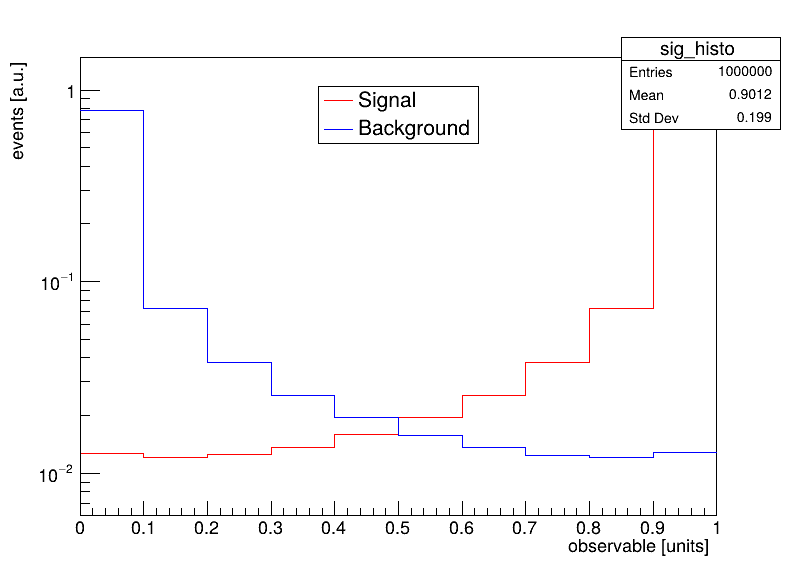

In [5]:
canvas = ROOT.TCanvas("canvas", "", 800, 600)
canvas.SetLogy()
sig_histo = ROOT.TH1F("sig_histo", "; observable [units]; events [a.u.]", 10, 0, 1)
bkg_histo = ROOT.TH1F("bkg_histo", "Background Histogram", 10, 0, 1)

# Fill histograms
sig_histo.FillN(len(signal_toy_data), signal_toy_data['observable'].values, np.ones(len(signal_toy_data)))
bkg_histo.FillN(len(background_toy_data), background_toy_data['observable'].values, np.ones(len(background_toy_data)))

# Normalize histograms

sig_histo.Scale(1.0 / sig_histo.Integral())
bkg_histo.Scale(1.0 / bkg_histo.Integral())


# Draw histograms
sig_histo.SetLineColor(ROOT.kRed)
bkg_histo.SetLineColor(ROOT.kBlue)

canvas.cd()
sig_histo.Draw("HIST")
bkg_histo.Draw("HIST SAME")


# build legend centered at top
legend = ROOT.TLegend(0.4, 0.75, 0.6, 0.85)
legend.AddEntry(sig_histo, "Signal", "l")
legend.AddEntry(bkg_histo, "Background", "l")
legend.Draw()
canvas.Draw()

# sig and bkg histo heights

sig_heights = []
bkg_heights = []
for bin_idx in range(1, sig_histo.GetNbinsX() + 1):
    sig_heights.append(sig_histo.GetBinContent(bin_idx))
    bkg_heights.append(bkg_histo.GetBinContent(bin_idx))
    print(f"Bin {bin_idx:2d}: Signal Height = {sig_histo.GetBinContent(bin_idx):8.3f}, Background Height = {bkg_histo.GetBinContent(bin_idx):8.3f}")
sig_heights = np.array(sig_heights)
bkg_heights = np.array(bkg_heights)



### Numpy version

In [6]:
# numpy version: calculate normalized bin heights

n_bins = 10
bin_range = (0, 1)

# Signal
sig_hist, bin_edges = np.histogram(signal_toy_data['observable'].values, bins=n_bins, range=bin_range, density=False)
sig_heights = sig_hist / sig_hist.sum()  # Normalize

# Background
bkg_hist, _ = np.histogram(background_toy_data['observable'].values, bins=n_bins, range=bin_range, density=False)
bkg_heights = bkg_hist / bkg_hist.sum()  # Normalize


for bin_idx in range(n_bins):
    print(f"Bin {bin_idx+1:2d}: Signal Height = {sig_heights[bin_idx]:8.3f}, Background Height = {bkg_heights[bin_idx]:8.3f}")


sig_heights = np.array(sig_heights)
bkg_heights = np.array(bkg_heights)

Bin  1: Signal Height =    0.013, Background Height =    0.778
Bin  2: Signal Height =    0.012, Background Height =    0.072
Bin  3: Signal Height =    0.013, Background Height =    0.038
Bin  4: Signal Height =    0.014, Background Height =    0.026
Bin  5: Signal Height =    0.016, Background Height =    0.019
Bin  6: Signal Height =    0.019, Background Height =    0.016
Bin  7: Signal Height =    0.025, Background Height =    0.014
Bin  8: Signal Height =    0.038, Background Height =    0.012
Bin  9: Signal Height =    0.072, Background Height =    0.012
Bin 10: Signal Height =    0.778, Background Height =    0.013


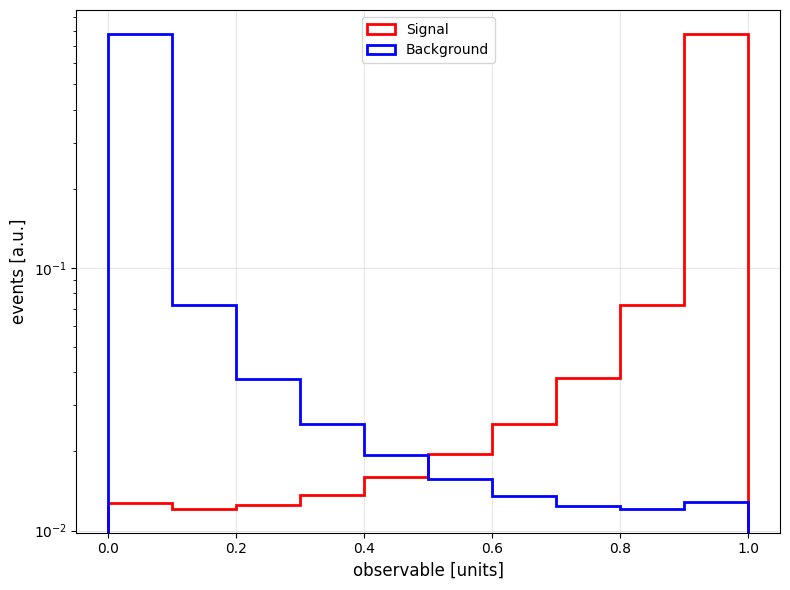

In [7]:
# Draw with matplotlib
fig, ax = plt.subplots(figsize=(8, 6))

# Create normalized weights for each dataset
sig_weights = np.ones(len(signal_toy_data)) / len(signal_toy_data)
bkg_weights = np.ones(len(background_toy_data)) / len(background_toy_data)

# Draw histograms with weights
ax.hist(signal_toy_data['observable'].values, bins=n_bins, range=bin_range, 
        weights=sig_weights, histtype='step', color='red', label='Signal', linewidth=2)
ax.hist(background_toy_data['observable'].values, bins=n_bins, range=bin_range, 
        weights=bkg_weights, histtype='step', color='blue', label='Background', linewidth=2)

# Configure logarithmic scale on y-axis
ax.set_yscale('log')

# Labels and legend
ax.set_xlabel('observable [units]', fontsize=12)
ax.set_ylabel('events [a.u.]', fontsize=12)
ax.legend(loc='upper center', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 2. Define Physics Parameters

In [8]:
# Cross sections (pb)
xs_signal = 2.0      # pb
xs_bkg = 250.0        # pb

# Efficiencies
eff_signal = 0.56
eff_bkg = 0.40

# Systematic uncertainties
syst_signal = 0.10   # 10%
syst_bkg = 0.15      # 15%

# Luminosity (fb^-1 -> pb^-1)
luminosity = 300e3   # pb^-1

print(f"Analysis parameters:")
print(f"  σ_signal = {xs_signal} pb")
print(f"  σ_background = {xs_bkg} pb")
print(f"  ε_signal = {eff_signal}")
print(f"  ε_background = {eff_bkg}")
print(f"  L = {luminosity/1e3} fb⁻¹")

Analysis parameters:
  σ_signal = 2.0 pb
  σ_background = 250.0 pb
  ε_signal = 0.56
  ε_background = 0.4
  L = 300.0 fb⁻¹


## 3. Normalize to the number of events

In [9]:
sig_heights = sig_heights * xs_signal * eff_signal * luminosity / sig_heights.sum()
bkg_heights = bkg_heights * xs_bkg * eff_bkg * luminosity / bkg_heights.sum()

## 4. Calculate Significance

In [10]:
def sig(s: np.ndarray, b: np.ndarray, sys_sig: float = 0.15, sys_bkg: float = 0.15) -> float:
    """
    Parameters:
    s : array_like
        Signal event counts in each bin (s_i)
    b : array_like
        Background event counts in each bin (b_i)
    sys_sig : float, optional
        Relative systematic uncertainty on signal (default: 0.15 = 15%)
    sys_bkg : float, optional
        Relative systematic uncertainty on background (default: 0.15 = 15%)

    Returns:
    kappa : float
        Discovery significance including systematics
    """
    # Convert to numpy arrays
    s = np.asarray(s)
    b = np.asarray(b)

    # Clip background to avoid division by zero
    b = np.clip(b, 1e-6, None)

    w = np.log(1 + s / b)

    sys_s_sq = (sys_sig * s)**2
    sys_b_sq= (sys_bkg * b)**2

    num = np.sum(s * w)
    sum_den = np.sum((s + b + sys_s_sq + sys_b_sq) * w**2)
    den = np.sqrt(sum_den)

    kappa = num / den

    return kappa

In [11]:
significance = sig(sig_heights, bkg_heights,syst_signal, syst_bkg)
print(f"Estimated significance (with systematics): {significance:.2f} σ")

Estimated significance (with systematics): 4.14 σ
